# Vigenere cipher cryptoanalysis


This notebook studies the cryptoanalysis of the [Vigenere][wiki] cipher, which is polyalphabetic, namely two occurrences  $a_{1}, a_{2}$ of character $a$ belonging to the plaintext are associated with occurrences $c_{1}, c_{2}$ in the ciphertext, such that $c_{1}\neq c_{2}$ with very high probability.

Our implementation closely follows a class lecture given by Prof. [Orazio Puglisi][puglisi] within Cryptography course at the University of Florence. In order to fully understand the last part, where the concept of *mutual coincidence index* is crucial, we rest on the explanation at pag. 20 of [this notes][notes].

[wiki]:https://en.wikipedia.org/wiki/Vigen%C3%A8re_cipher
[puglisi]:http://web.math.unifi.it/users/puglisi/
[notes]:http://iml.univ-mrs.fr/~ritzenth/cours/crypto.general.pdf

In [3]:
import itertools
from itertools import *
from copy import copy, deepcopy
from heapq import *
from random import *
import matplotlib.pyplot as plt
from collections import Counter
from sympy import *

init_printing()

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)

---

Let $\mathcal{A}$ be our alphabet composed of standard English characters plus the `space` character. It will be sufficient to encode simple and (not so quite) short messages. To define it as a group $\frac{\mathbb{Z}}{n\mathbb{Z}}$ in the Python language we use a `dict` object, which can be reversed because it is a bijection.

In [4]:
def make_alphabet_entry(i):
    alpha = i + ord('a')
    return chr(alpha),i

A = dict(map(make_alphabet_entry, range(26)))
A.update({' ':26})
inverse_A = {v:k for k,v in A.items()}

A

{' ': 26,
 'a': 0,
 'b': 1,
 'c': 2,
 'd': 3,
 'e': 4,
 'f': 5,
 'g': 6,
 'h': 7,
 'i': 8,
 'j': 9,
 'k': 10,
 'l': 11,
 'm': 12,
 'n': 13,
 'o': 14,
 'p': 15,
 'q': 16,
 'r': 17,
 's': 18,
 't': 19,
 'u': 20,
 'v': 21,
 'w': 22,
 'x': 23,
 'y': 24,
 'z': 25}

We define a function `encode` that consumes a string and produces a list of integer in our field. In parallel, function `decode` goes backwards, it consumes a list of integers and return a string. Such functions are useful in order to use the cipher and analyze it using `str` objects instead of the coded version using lists of integers.

In [5]:
def encode(s, alphabet=A): return list(map(lambda i: alphabet[i], s))

def decode(e, inverse_alphabet=inverse_A): return "".join(map(lambda i: inverse_alphabet[i], e))

The following plaintext is a prose taken from [here]; before using it we have to swipe out punctuation marks:

[here]:http://www.bartleby.com/209/2.html

In [6]:
def clean_text(text):
    remove_chars = [',', '.', ';', ':', '-', '(', ')', "'", '"']
    for rc in remove_chars: text = text.replace(rc, '')
    text = text.replace('\n', ' ')

    return "".join(filter(lambda c: not c.isdigit(), text))

with open('rest_plain_text.txt', 'r') as f:
    plain_text = clean_text(f.read().lower())
    
encoded_plain_text = encode(plain_text)

plain_text, len(plain_text)

('the attraction of medieval literature comes perhaps more strongly from some other countries than from england in france and provence in germany and iceland there were literary adventurers more daring and achievements more distinguished it was not in england that the most wonderful things were produced there is nothing in old english that takes hold of the mind with that masterful and subduing power which still belongs to the lyrical stanzas of the troubadours and minnesingers to welsh romance or to the epic prose of the iceland histories   the norman conquest degraded the english language from its literary rank and brought in a new language for the politer literature it did not destroy in one sense it did not absolutely interrupt english literature but it took away the english literary standard and threw the country back into the condition of italy before dantean anarchy of dialects when a new literary language was established in the time of chaucer the middle ages were nearly over a

With the following assert we ensure that function `decode` is the inverse of function `encode`:

In [8]:
assert decode(encode(plain_text)) == plain_text

Let $\textbf{k}=(k_{0},\ldots,k_{m-1}) \in \left(\frac{\mathbb{Z}}{n\mathbb{Z}}\right)^{m}$ be a *key* of length $m\in\mathbb{N}$. In order to have a meaningful analysis we build a function `generate_random_key` which generate a random key of random length, keeping it safe...we will uncover it only at the end to check our work:

In [9]:
def generate_random_key(given_key=None, required_length=None, max_length=None, alphabet=A):
    
    if given_key is not None: return given_key
    
    if required_length is None and max_length is None: max_length = len(alphabet)
    
    # the minimum length of the key is 3 to build interesting cases
    length = required_length if required_length else randint(3, max_length)
    key = [0] * length
    # -1 in the following max limit because it is inclusive in the sense of `randint`.
    for i in range(length): key[i] = randint(0, len(alphabet)-1)
    return key

#key = encode("ericsmullyan")
secret_key = generate_random_key(required_length=17)

Now we are in the position to define `encrypt` and `decrypt` functions, both of them consumes an *encoded* message, namely a list of integers, and a key. The encryption work by repeating the key as long as necessary to match the same length of the input $\textbf{x}=(x_{0},\ldots,x_{h})$, where $h > m-1$ otherwise the cipher is a *OneTimePad* which is unbreakable, 
$$(\underbrace{x_{0},\ldots,x_{m-1}}_{k_{0},\ldots,k_{m-1}}
\underbrace{x_{m},\ldots,x_{m-1}}_{k_{0},\ldots,k_{m-1}}
\ldots
\underbrace{x_{lm},\ldots,x_{h}}_{k_{0},\ldots,k_{h \mod m}}) = 
(y_{0},\ldots,y_{h}) = \textbf{y}$$
truncating the very right block to match plaintext suffix. At last, the ciphertext $\textbf{y}$ is obtained by addition modulo $n$ of corresponding symbols, where $n$ is the length of the alphabet. Decryption follows the same scheme, using modular subtraction.

In [10]:
def encrypt(message, key, alphabet=A):
    n = len(alphabet)
    return [(p+v)%n for p,v in zip(message, cycle(key))]

def decrypt(cipher, key, alphabet=A):
    n = len(alphabet)
    return [(c-v)%n for c,v in zip(cipher, cycle(key))]

the following is the *ciphertext* produced by the application of function `encrypt` to the plaintext:

In [11]:
cipher_text = encrypt(encoded_plain_text, secret_key)
decode(cipher_text)

'yvgtwwvasavg lcide gxdhxkcyngecuvrzegtyroojyrccfdjqe qk cucimpexwc pt bljpgjfrjccyfissgtb vbczzpyrprgyjaiewqfj lbdczqxceopxvstymcpaqylhylstfwq jslfyuahfzsrbmchtorugpqyocrjecktccnmcprfphlqe qk cfkigpelzqyyfqjb ygwwlvqlkrlcerklolpqlgufqbccrejclvqqcrgpyqljfzsrbmcdvjkfgyymvnyabpx uhdcyvfuljmyastyvstyvsecpywbcwsbbncpykfklsylhytzft qiv qjyefdnyyomyncjycbbmrywbce kgzcyskfbrtzwukffvymiwvrzpblqxwbzwp vsqfwpbutgfbyxgkegcdocmpedywiyyvgtgatsuznydrdhxffbhacvrwyvp sevbthtlvdpnrkklzcvcllstlvwqjncnqtyuikfaeyvrtjkmbrtccznnqbimruormhyefhughsnuigbr qvmcghmyenva cpyikcllarhozsumvggqizfcpywbcesp glurrjclssdacetthhckcjyngecuvpcntuinbkebb cmxafynkgvdbxwubjmljozlsbzjubczcbn jlncwnnbohtkkstclgwubnrbgjwbnwqvp wcclebpyvvgxjcbgeygcbeaqmvddbfjwrqjaugsggkmxrcrcpexgvbyqwvymdvdicb frccregqhfccfswbrtcczllzklccnskctzcwcmrfafumgbkebbrtphqyyvgtyrwxkp ynzfeynavhvwjoraqlpgwcmsnqzvlvkcwb qdrlcercgohcxrzpzcaksyttbxddnouruyhfhhyfnpyrcnskctzcwcfzsuwubhbfsqbcdrdwjnfjyzckxrrjclrlgcebhtykcductyefhuknrfe ccqwqbuqphuljotetcqewpbzz

Assuming to know the `secret_key`, we ensure that function `decrypt` is the inverse of function `encrypt`:

In [12]:
assert decode(decrypt(cipher_text, secret_key)) == plain_text

Let $I_{c}$ be the *coincidence index* of a sequence $\alpha$, over an alphabet $A$, defined as 
$$ I_{c}(\alpha) = \sum_{i=0}^{n}{\frac{f_{a_{i}}^{(\alpha)}(f_{a_{i}}^{(\alpha)}-1)}{m(m-1)}} $$ where $n$ is the length of the alphabet, $m$ is the length of $\alpha$ and $f_{a_{i}}^{^{(\alpha)}}$ is the frequency of symbol $a_{i}\in A$, namely the number of occurrences of $a_{i}$, in $\alpha$. In other words, $I_{c}$ is the probability to sample two occurrences of the same symbol $a$, forall $a\in A$, from the sequence $\alpha$. 

Index $I_{c}$ is invariant to shifting by the same constant $v$. Let $\alpha,\beta$ be two sequences of integers of length $l$ such that $\beta_{i} \equiv_{n} \alpha_{i} + v$, forall $i\in\lbrace0,\ldots,l\rbrace$; moreover, let $q_{\gamma_{i}}^{(\gamma)}$ be the probability to sample *two* occurrences of $\gamma_{i}$ from a sequence $\gamma$, we can state the relations
$$
    I_{c}(\beta) = \sum_{a_{i}\in\frac{\mathbb{Z}}{n\mathbb{Z}}}{q_{a_{i}}^{(\beta)}}
                = \sum_{a_{i}\in\frac{\mathbb{Z}}{n\mathbb{Z}}}{q_{a_{i}-v}^{(\alpha)}}
                = \sum_{\hat{a}_{i}\in\frac{\mathbb{Z}}{n\mathbb{Z}}}{q_{\hat{a}_{i}}^{(\alpha)}}
                = I_{c}(\alpha)
$$
where $\hat{a}_{i}\equiv_{n}a_{i}-v$, proving the invariance of $I_{c}$ when a sequence is produced by another one shifted by a constant $v\in\frac{\mathbb{Z}}{n\mathbb{Z}}$.

In [30]:
def frequencies(lst, alphabet=A, inverse_alphabet=inverse_A):
    """ Produces a `dict` counting occcurrences of each object of the alphabet within the iterable.
    
    `frequencies` consumes an iterable $lst$ and an alphabet $A$, 
    produces a dictionary of entries $(k,v)$ where $k$ is a character 
    in $A$ and $v$ is the number of occurrences of $k$ in $lst$
    """
    counter = Counter(lst)
    return {k:counter[v] if v in counter else 0 for k,v in alphabet.items()}
    
def length_from_frequencies(freqs):
    """ Returns the length of the original sequence by summation of symbols frequencies. """
    return sum(v for v in freqs.values())

def coincidence_index(freqs, alphabet=A):
    """ Produces the I_{c} relative to frequencies matched against an alphabet. """
    denom = length_from_frequencies(freqs)
    if denom in range(2): return None
    def mapper(a):
        v = freqs[a] if a in freqs else 0
        return v*(v-1)
    return sum(map(mapper, alphabet.keys()))/(denom*(denom-1))

def draw_frequencies_histogram(seq, alphabet=A, y_maxlimit=None, normed=None):
    
    #plaintext_length = len(plain_text)
    #freqs = [plaintext_frequencies[inverse_A[ia]] for ia in sorted(inverse_A.keys())]
    n, bins, patches = plt.hist(seq, len(alphabet), normed=normed,facecolor='green', alpha=0.5)

    plt.xlabel('alphabet symbols')
    plt.ylabel('frequencies' + (', normed respect: {}'.format(str(normed)) if normed else ''))
    plt.xticks(range(-1, len(alphabet)), sorted(alphabet.keys()))
    if y_maxlimit: plt.ylim([0, y_maxlimit])
    plt.grid(True)
    plt.show()
    
    return None

The following are frequencies of alphabet symbols in the *plaintext*: in the analysis they are used as a `dict` produced by function `frequencies`, moreover it is possible to draw an histogram with the relative function.

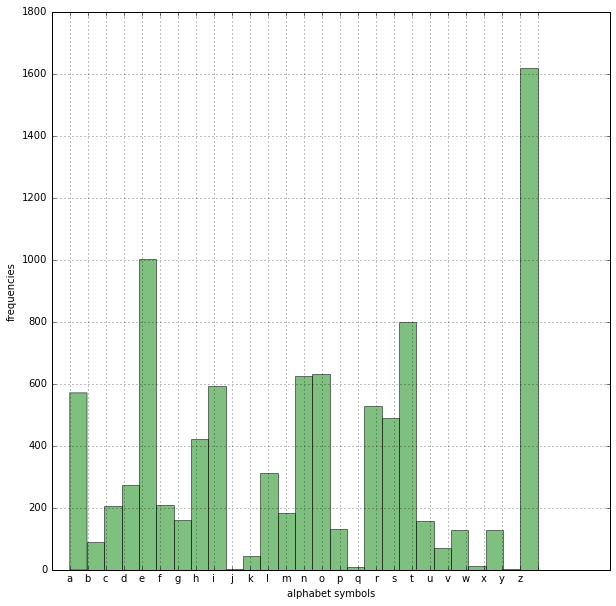

In [31]:
plaintext_frequencies = frequencies(encoded_plain_text)
draw_frequencies_histogram(encoded_plain_text, y_maxlimit=1800)

In [32]:
plaintext_frequencies

{' ': 1620,
 'a': 571,
 'b': 90,
 'c': 207,
 'd': 272,
 'e': 1001,
 'f': 208,
 'g': 162,
 'h': 422,
 'i': 594,
 'j': 2,
 'k': 46,
 'l': 312,
 'm': 184,
 'n': 624,
 'o': 633,
 'p': 131,
 'q': 8,
 'r': 529,
 's': 490,
 't': 800,
 'u': 158,
 'v': 71,
 'w': 129,
 'x': 13,
 'y': 129,
 'z': 2}

The following histogram shows frequencies in the *ciphertext*: using the same `y_maxlimit` value, we see that they are spread "uniformly" over symbols.

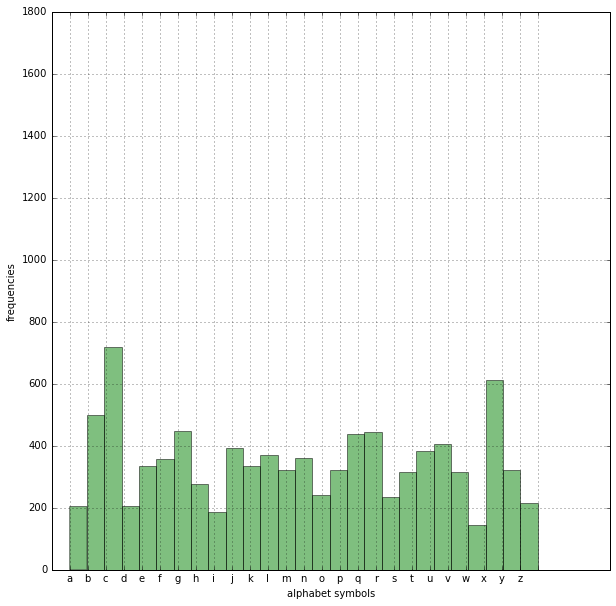

In [29]:
draw_frequencies_histogram(cipher_text, y_maxlimit=1800)

A first approach to encryption finishes computing the coincidence indexes of both *plaintext* and *ciphertext*:

In [100]:
print("coincidence index of *plaintext*: {}\ncoincidence index of *ciphertext*: {}".format(
        coincidence_index(plaintext_frequencies), coincidence_index(frequencies(cipher_text))))

coincidence index of *plaintext*: 0.07720140650073147
coincidence index of *ciphertext*: 0.04092000890927222


In [112]:
def spread(message, block_length):
    return [message[i:i+block_length] for i in range(0, len(message), block_length)]
    
def col(spreaded, c, join=False, joiner=lambda c: ''.join(decode(c))):
    column = [lst[c] if c < len(lst) else None for lst in spreaded]
    ready = list(filter(lambda i: i is not None, column))
    return joiner(ready) if join else ready

def decode_spreaded(spreaded, join_as_str=False):
    decoded_spread = list(map(decode, spreaded))
    return '\n'.join(decoded_spread) if join_as_str else decoded_spread

def analyze(cipher_text, max_key_length=None):
    res = {}
    # we discard the case where the key length equals the
    # length of the cipher text, since it is the case of 
    # OneTimePad cipher, which is unbreakable!
    for d in range(2, len(cipher_text) if max_key_length is None else max_key_length + 1):
        spreaded = spread(cipher_text, d)
        res[d] = []
        for c in range(d):
            ci = coincidence_index(frequencies(col(spreaded, c)))
            if ci: res[d].append(ci)
                
    return res

def guess_key_length(analysis, threshold=0.06):
    candidates = {}
    for k,v in analysis.items():
        cs = list(filter(lambda i: i > threshold, v))
        if cs and len(cs) > ceiling(k/2): candidates[k] = cs
    return candidates

def scores(candidates, key_length):
    return candidates[key_length] if key_length in candidates else None

The above set of functions allows us to probe the key *length* by repeatedly fixing a candidate length $l$, then spreading the *ciphertext* in a matrix with $l$ columns, then computing $I_{c}$ of each column and, finally, report $l$ if the majority of $I_{c}$ scores is greater than a threshold (.06 for English).

In [110]:
analysis = analyze(cipher_text, max_key_length=20)
# analysis # delete the first `#` comment symbol in order to discover candidates key lengths

here are $I_{c}$ scores witnesses for the candidate key length:

In [114]:
probing_key_length = 17
scores(guess_key_length(analysis), probing_key_length)

The following is the *ciphertext* spread over a matrix with a number of column equals the candidate length found in the previous cell.

In [107]:
decode_spreaded(spread(cipher_text, probing_key_length))

['au fsda wpfefwlkq',
 'hz j pcjgmyekncxd',
 'bd fuzunnmbaiqmlc',
 'hzjxwk bma ccglbb',
 'wzvyfxmijfuaiioke',
 'vfmowchbcn wx  ik',
 'm brsylid mbijzzp',
 'hnijr zxqr zwiujk',
 'ormssyfiw qw lqhl',
 'vqvzzpznvirnwixed',
 'mdwxpkimqr pl qnc',
 'hzjxwkljmv crjz k',
 'ipcowfmv  forv np',
 'hqdyktvppvedwmled',
 'hiwyrywbvv wwwshl',
 'vqvzzlaiourwdxdpk',
 'daijwbncgmfd wsok',
 'drmkr zxzgpaviedp',
 'zrvojkvxouvjyiujk',
 'wyzfwyoudeuwkqmpk',
 'anfkjkpxgqmkxiedp',
 'hzdtvkdroumpzjewx',
 'ieokiqbuvn  rafyo',
 'bvimr we dmszrodk',
 ' fdrckjnga cjiekk',
 'au fcizrynywjbmjj',
 'ievuxkaq mfnfcnxo',
 'wgmyrlvmvzvjendey',
 'ormyrdwirryozickx',
 'i ykrzzioampznla ',
 'qpvviz nvaswkqqwt',
 'krggeohqdefkirqok',
 'hmonwkvxmznjrl ja',
 'brnzrompmnqaviedp',
 'hrimct qvynjycmcp',
 'hsmudkqbnmyekncxb',
 'fmmgevhjiqmyixfcs',
 'amdtrlhw imhswsql',
 'orvlfbhbcrmlfuupp',
 'zmgokpzjogdarrewo',
 'qqvtfdhm efnfgley',
 'haikrcmwnrmekipeo',
 'h jzrljajygpwujwt',
 'vf xiexbvr ccrddk',
 'tvokilacmrmylbled',
 'hfjubkie

Once the length $m$ of key $\textbf{k}$ has been "established", we're left with finding actual key symbols $k_{i}$, for $i\in\{0,\ldots,m-1\}$. In order to fullfil this step, we need another object, which resembles the index of mutual coincidence $I_{c}$ but it is more general, in the sense that sampling occurs on two given sequences instead of the same one. Formally, let $I_{mc}(\alpha, \beta)$ be the *index of mutual coincidence* of sequences $\alpha$ and $\beta$, defined as
$$
I_{mc}(\alpha,\beta) = \sum_{a_{i}\in\frac{\mathbb{Z}}{n\mathbb{Z}}}{q_{a_{i}}^{(\alpha)}q_{a_{i}}^{(\beta)}}
$$
where $q_{a_{i}}^{(\nu)}$ is the probability to draw an occurrence of symbol $a_{i}$ in sequence $\nu$.

Let $\eta$ and $\gamma$ be two sequences of length $l$, produced by adding shifts $v_{\alpha}$ and $v_{\beta}$ to sequences $\alpha$ and $\beta$, respectively (formally, $\eta_{i} \equiv_{n} \alpha_{i} + v_{\alpha}$ and $\gamma_{i} \equiv_{n} \beta_{i} + v_{\beta}$, forall $i\in\lbrace0,\ldots,l-1\rbrace$). The inequality
$$
    I_{mc}(\eta,\gamma) 
                = \sum_{a_{i}\in\frac{\mathbb{Z}}{n\mathbb{Z}}}{q_{a_{i}}^{(\eta)}q_{a_{i}}^{(\gamma)}}
                = \sum_{a_{i}\in\frac{\mathbb{Z}}{n\mathbb{Z}}}{q_{a_{i}-v_{\alpha}}^{(\alpha)}q_{a_{i}-v_{\beta}}^{(\beta)}}
                = \sum_{a_{i}\in\frac{\mathbb{Z}}{n\mathbb{Z}}}{q_{a_{i}}^{(\alpha)}q_{a_{i}+v_{\alpha}-v_{\beta}}^{(\beta)}}
                \neq \sum_{a_{i}\in\frac{\mathbb{Z}}{n\mathbb{Z}}}{q_{a_{i}}^{(\alpha)}q_{a_{i}}^{(\beta)}}
                = I_{mc}(\alpha,\beta)
$$
holds unless factor $v_{\alpha}-v_{\beta}$ in each subscript. We can define an even more general version of $I_{mc}$ as
$$
    I_{mc}(\eta,\gamma,g) 
                = \sum_{a_{i}\in\frac{\mathbb{Z}}{n\mathbb{Z}}}{q_{a_{i}-g}^{(\eta)}q_{a_{i}}^{(\gamma)}}
                = \sum_{a_{i}\in\frac{\mathbb{Z}}{n\mathbb{Z}}}{q_{a_{i}}^{(\alpha)}q_{a_{i}+v_{\alpha}-v_{\beta}+g}^{(\beta)}}
$$
where sequence $\eta$ is shifted back by $g\in\mathbb{N}$. Therefore we can state the equality with the usual definition according to
$$
    I_{mc}(\eta,\gamma,g) = I_{mc}(\alpha,\beta) \leftrightarrow v_{\beta}-v_{\alpha}=g
$$
proving the invariance of $I_{mc}$ when two sequences are produced by shifting two other ones by constant values $q,w$ respectively, providing that $g = w-q$.

In [117]:
def mutual_coincidence_index(fst_freqs, snd_freqs, offset=0, 
                             alphabet=A, inverse_alphabet=inverse_A):
    fst_len = length_from_frequencies(fst_freqs)
    snd_len = length_from_frequencies(snd_freqs)
    n = len(alphabet)
    return sum(fst_freqs[k] * snd_freqs[inverse_alphabet[(v+offset) % n]] 
               for k,v in alphabet.items())/(fst_len * snd_len)

Previous generalization allows us to set the basis to break the cipher. It works as follows: for each pair $(\eta,\gamma)$ of different columns in the spread-matrix form of the *ciphertext*, fix a $g\in\frac{\mathbb{Z}}{n\mathbb{Z}}$ to compute $I_{mc}(\eta,\gamma,g)$: if such index value is close to $I_{c}(\nu)$, where $\nu$ is a structured sequence using the English language, namely close to $0.065$, then collect equation $k_{i(\beta)}-k_{i(\alpha)}=g$, where function $i(\nu)$ return the zero-based index of column $\nu$ in the matrix spread. Such equations are important since state difference relations over symbols of the key.

In [118]:
def build_offsets_eqs(cipher_text, key_length, indexed_sym, threshold=.06, alphabet=A):
    
    n = len(alphabet)
    eqs = {c:{} for c in range(key_length)}
    spreaded = spread(cipher_text, key_length)
    for c,a in itertools.product(range(key_length), repeat=2):
    
        if a == c: continue
        
        eqs[c][a]=[]
        
        for g in range(1,n):
            column_freqs = frequencies(col(spreaded, c))
            another_freqs = frequencies(col(spreaded, a))
            mci = mutual_coincidence_index(column_freqs, another_freqs, g)
            if mci > threshold: 
                eqs[c][a].append(tuple([Eq(indexed_sym[a]-indexed_sym[c],g,evaluate=True), mci]))
    
    return eqs

In [119]:
k_sym=IndexedBase('k')

eqs_dict = build_offsets_eqs(cipher_text, key_length=probing_key_length, indexed_sym=k_sym)

The following cell report the set of difference equation collected respect the *first* column of the spread matrix: we observe that such set fails to instantiate $k_{6}$ because no likely equation gives a relation for it. On the contrary, it can be the case that collecting equations for a pair of columns with indexes $(c,a)$ yields one or more equations, namely $\{k_{a}-k_{c}=g_{u_{0}},\ldots,k_{a}-k_{c}=g_{u_{v}}\}$, for some $v\in\mathbb{N}$: to properly explore all keys space, we have to consider the product of each list of "equally-likely" equations.

In [129]:
eqs_dict[0]

In [121]:
def clean_mci_info(eqs_dict):
    
    res = {}
    for c, eq_dict in eqs_dict.items():
        eqs_list = []
        for a, eqs in eq_dict.items():
            if not eqs: 
                eqs_list = []
                break
            eqs_list.append([[a] + list(eq_pair) for eq_pair in eqs])
        res[c]=list(itertools.product(*eqs_list))
    
    return res

The above function implements the last observation, namely it produces the complete keys space where we've to look for the good one.

In [128]:
eqs_dict_pure = clean_mci_info(eqs_dict)
eqs_dict_pure

In [168]:
def candidate_keys(eqs_dict, indexed_sym, alphabet=A):
    key_length = len(eqs_dict)
    n = len(alphabet)
    candidates=set()
    for c, eqs_tuples in eqs_dict.items():
        for d in range(len(alphabet)):
            for eq_tuple in eqs_tuples:
                key = [indexed_sym[i] for i in range(key_length)]
                key[c] = d
                for a, eq, mci in eq_tuple:
                    subs_eq = eq.subs(indexed_sym[c],d)
                    key[a] = solve(subs_eq, indexed_sym[a])[0]
                    key[a] = key[a] % n

                key_is_fully_instantiated = True
                for k in key:
                    if isinstance(k, Indexed): key_is_fully_instantiated = False 
                
                # `tuple` application to make `key` hashable
                if key_is_fully_instantiated: candidates.add(tuple(key)) 
            
    return candidates

In order to instantiate candidates keys, for each index column $c$ we use the set of equations $\{k_{a}-k_{c}=g_{u}\}$, for some $u\in\mathbb{N}$ and $a\in\{0,\ldots,m-1\}\setminus\{c\}$ as follows: for each equation $k_{a}-k_{c}=g_{u}$, instantiate $k_{c} = s$, for $s\in\frac{\mathbb{Z}}{n\mathbb{Z}}$, and solve it respect $k_{a}$. Therefore for each column index $c$ we have a candidate key if each symbol $k_{i}$ has been instantiated.

In [162]:
possible_keys = candidate_keys(eqs_dict_pure, k_sym)

In [163]:
def arbitrary_frequencies(length, filename='rest_plain_text.txt'):
    with open(filename, 'r') as f:
        text = clean_text(f.read().lower())
    text = text[:length]
    return frequencies(encode(text))

def attempt_keys(candidate_keys, cipher_text, threshold=.06, arbitrary_freqs=None):
    sols = set()
    for key in candidate_keys:
        decrypted = decrypt(cipher_text, key)
        freqs = frequencies(decrypted)
        if arbitrary_freqs:
            good = True
            for k,v in arbitrary_freqs.items():
                if 1-abs((freqs[k]-v)/v) < .6: good = False
            if good: sols.add(decode(key))
        else:
            ci = coincidence_index(freqs)
            if ci > threshold: sols.add(decode(key))#sols.add((ci, decode(key)))
    return sols

The last step to filter out mistaken keys, we use each candidate key to perform a decryption, checking it against frequencies of an arbitrary English prose:

In [164]:
sols = attempt_keys(possible_keys, cipher_text, arbitrary_freqs=arbitrary_frequencies(len(cipher_text)))

In [169]:
len(sols), sols

(1, {'inwgslijwnnxsjmxl'})

In [166]:
for sol in sols: 
    key = sol
    print("key:({})\nplaintext:\n{}\n\n".format(
            key, decode(decrypt(cipher_text, encode(key)))))

key:(inwgslijwnnxsjmxl)
plaintext:
the attraction of medieval literature comes perhaps more strongly from some other countries than from england in france and provence in germany and iceland there were literary adventurers more daring and achievements more distinguished it was not in england that the most wonderful things were produced there is nothing in old english that takes hold of the mind with that masterful and subduing power which still belongs to the lyrical stanzas of the troubadours and minnesingers to welsh romance or to the epic prose of the iceland histories   the norman conquest degraded the english language from its literary rank and brought in a new language for the politer literature it did not destroy in one sense it did not absolutely interrupt english literature but it took away the english literary standard and threw the country back into the condition of italy before dantean anarchy of dialects when a new literary language was established in the time of chaucer t

In [150]:
decode(secret_key)

'inwgslijwnnxsjmxl'

**:)**

---

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">Vigenere cryptoanalysis</span> by <a xmlns:cc="http://creativecommons.org/ns#" href="mailto:massimo.nocentini@unifi.it" property="cc:attributionName" rel="cc:attributionURL">Massimo Nocentini</a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.<br />Based on a work at <a xmlns:dct="http://purl.org/dc/terms/" href="https://github.com/massimo-nocentini/scratchpad/blob/master/chapters/crypto/vigenere-cryptoanalysis.ipynb" rel="dct:source">https://github.com/massimo-nocentini/scratchpad/blob/master/chapters/crypto/vigenere-cryptoanalysis.ipynb</a>.